<a href="https://colab.research.google.com/github/eddylae/macroeconomics/blob/main/Econ126_Class_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import linearsolve as ls
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

ModuleNotFoundError: ignored

# Class 17: Introduction to New-Keynesian Business Cycle Modeling

In this notebook, we will use `linearsolve` to compute impulse responses of output, inflation, and the nominal interest rate to an aggregate demand shock in the New-Keynesian model.

## The New-Keynesian Model

The most basic version of the New-Keynesian Model can be expressed as:

\begin{align}
\beta y_t & = E_t y_{t+1}  - \left( r_{t} - \bar{r}\right) + g_t\\
i_{t} & = r_{t} + E_t \pi_{t+1}\\
i_{t} & = \bar{r} + \pi^T + \phi_{\pi}\big(\pi_t - \pi^T\big) + \phi_{y}\big(y_t - \bar{y}\big) + v_t\\
\pi_t -\pi^T & = \beta \left( E_t\pi_{t+1} - \pi^T\right)  + \kappa (y_t -\bar{y})+ u_t,
\end{align}

where: $y_t$ is (log) output, $r_t$ is the real interest rate, $i_t$ is the nominal interest rate, $\pi_t$ is the rate of inflation between periods $t-1$ and $t$, $\bar{r}$ is the long-run average real interest rate or the *natural rate of interest*, $\beta$ is the household's subjective discount factor, and $\pi^T$ is the central bank's inflation target. The coeffieints $\phi_{\pi}$ and $\phi_{y}$ reflect the degree of intensity to which the central bank *endogenously* adjusts the nominal interest rate in response to movements in inflation and output.

The variables $g_t$, $u_t$, and $v_t$ represent exogenous shocks to aggregate demand, inflation, and monetary policy. They follow AR(1) processes:

\begin{align}
g_{t+1} & = \rho_g g_{t} + \epsilon^g_{t+1}\\
u_{t+1} & = \rho_u u_{t} + \epsilon^u_{t+1}\\
v_{t+1} & = \rho_v v_{t} + \epsilon^v_{t+1}.
\end{align}

The goal is to compute impulse responses in the model to a one percent exogenous increase in the nominal interest rate. We will use the following parameterization:

| $$\bar{y}$$ | $$\beta$$ | $$\bar{r}$$    | $$\kappa$$ | $$\pi^T$$ | $$\phi_{\pi}$$ | $$\phi_y$$ | $$\rho_g$$ | $$\rho_u$$ | $$\rho_v$$ |
|-------------|-----------|----------------|------------|-----------|----------------|------------|------------|------------|------------|
| 0           | 0.995     | $$-\log\beta$$ | 0.25        | 0.02/4    | 1.5            | 0.5/4      | 0.5        | 0.5        | 0.5        |

In [ ]:
# Create a variable called 'parameters' that stores the model parameter values in a Pandas Series
parameters = pd.Series(dtype=float)
parameters['y_bar'] = 0
parameters['beta'] = 0.995
parameters['r_bar'] = -np.log(parameters.beta)
parameters['kappa'] = 0.25
parameters['pi_T'] = 0.02/4
parameters['phi_pi'] = 1.5
parameters['phi_y'] = 0.5/4
parameters['rho_g'] = 0.5
parameters['rho_u'] = 0.5
parameters['rho_v'] = 0.5

# Print the model's parameters
print(parameters)

y_bar     0.000000
beta      0.995000
r_bar     0.005013
kappa     0.250000
pi_T      0.005000
phi_pi    1.500000
phi_y     0.125000
rho_g     0.500000
rho_u     0.500000
rho_v     0.500000
dtype: float64


In [ ]:
# Create variable called 'var_names' that stores the variable names in a list with exogenous state variables
# ordered first, endogenous state variables ordered second, and control variables ordered last.
var_names = ['g','u','v','y','pi','i','r']

# Create variable called 'shock_names' that stores an exogenous shock name for each exogenous state variable.
shock_names = ['e_g','e_u','e_v']

# Define a function that evaluates the equilibrium conditions of the model solved for zero. PROVIDED
def equilibrium_equations(variables_forward,variables_current,parameters):

    # Parameters. PROVIDED
    p = parameters

    # Current variables. PROVIDED
    cur = variables_current

    # Forward variables. PROVIDED
    fwd = variables_forward

    # IS equation
    is_equation = fwd.y - (cur.r -p.r_bar) + cur.g - cur.y

    # Fisher_equation
    fisher_equation = cur.r + fwd.pi - cur.i

    # Monetary policy
    monetary_policy = p.r_bar + p.pi_T + p.phi_pi*(cur.pi - p.pi_T) + p.phi_y*cur.y + cur.v - cur.i

    # Phillips curve
    phillips_curve = p.beta*(fwd.pi- p.pi_T) + p.kappa*cur.y + cur.u - (cur.pi-p.pi_T)

    # Demand process
    demand_process = p.rho_g*cur.g - fwd.g

    # Monetary policy process
    monetary_policy_process = p.rho_v*cur.v - fwd.v

    # Inflation process
    inflation_process = p.rho_u*cur.u - fwd.u

    # Stack equilibrium conditions into a numpy array
    return np.array([
            is_equation,
            fisher_equation,
            monetary_policy,
            phillips_curve,
            demand_process,
            monetary_policy_process,
            inflation_process
        ])

# Initialize the model into a variable named 'nk_model'
nk_model = ls.model(equations = equilibrium_equations,
                    n_states=3,
                    n_exo_states = 3,
                    var_names=var_names,
                    shock_names=shock_names,
                    parameters = parameters)

In [ ]:
# Compute the steady state numerically using .compute_ss() method of nk_model
guess = [0,0,0,0,0.01,0.01,0.01]
nk_model.compute_ss(guess)

# Print the computed steady state
print(nk_model.ss)

g     1.379068e-34
u     2.578505e-34
v    -2.700350e-34
y     3.705259e-20
pi    5.000000e-03
i     1.001254e-02
r     5.012542e-03
dtype: float64


In [ ]:
# Find the log-linear approximation around the non-stochastic steady state and solve using .approximate_and_solve() method of nk_model
# set argumement 'log_linear' to False because the model is already log-linear.
nk_model.approximate_and_solve(log_linear=False)

print(nk_model.approximated())

Linear equilibrium conditions:

       y[t+1|t] = -g[t]+y[t]+r[t]

      pi[t+1|t] = i[t]-r[t]

              0 = -v[t]-0.125·y[t]-1.5·pi[t]+i[t]

0.995·pi[t+1|t] = -u[t]-0.25·y[t]+pi[t]

        -g[t+1] = -0.5·g[t]

        -v[t+1] = -0.5·v[t]

        -u[t+1] = -0.5·u[t]


### Impulse Responses

Compute a 21 period impulse response of the model's variables to a 0.01 unit shock to the aggregate demand for goods ($g_t$) in period 5.

In [ ]:
# Compute impulse responses
nk_model.impulse(T=21,t0=5,shocks=[0.01,0,0])

# Print the first 10 rows of the computed impulse responses to the demand shock
print(nk_model.irs['e_g'].head(10))

    e_g         g    u    v         y        pi         i         r
0  0.00  0.000000  0.0  0.0  0.000000  0.000000  0.000000  0.000000
1  0.00  0.000000  0.0  0.0  0.000000  0.000000  0.000000  0.000000
2  0.00  0.000000  0.0  0.0  0.000000  0.000000  0.000000  0.000000
3  0.00  0.000000  0.0  0.0  0.000000  0.000000  0.000000  0.000000
4  0.00  0.000000  0.0  0.0  0.000000  0.000000  0.000000  0.000000
5  0.01  0.010000  0.0  0.0  0.008909  0.004432  0.007762  0.005546
6  0.00  0.005000  0.0  0.0  0.004454  0.002216  0.003881  0.002773
7  0.00  0.002500  0.0  0.0  0.002227  0.001108  0.001940  0.001386
8  0.00  0.001250  0.0  0.0  0.001114  0.000554  0.000970  0.000693
9  0.00  0.000625  0.0  0.0  0.000557  0.000277  0.000485  0.000347


Plot the computed impulses responses of the nominal interest rate, the real interest rate, output, and inflation. Express inflation and interest rates in *annualized* (e.g., multiplied by 4) terms.

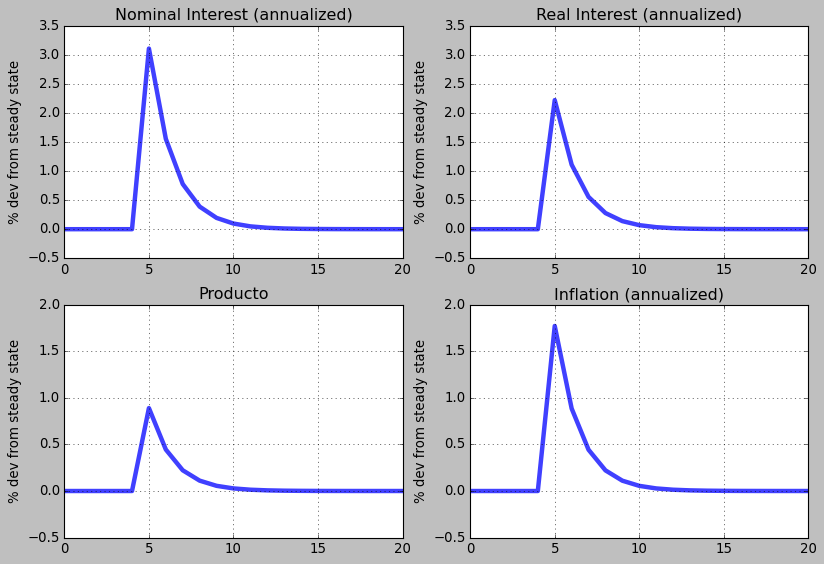

In [ ]:
# Create figure. PROVIDED
fig = plt.figure(figsize=(12,8))

# Create upper-left axis. PROVIDED
ax1 = fig.add_subplot(2,2,1)
# Create upper-right axis. PROVIDED
ax2 = fig.add_subplot(2,2,2)
# Create lower-left axis. PROVIDED
ax3 = fig.add_subplot(2,2,3)
# Create lower-right axis. PROVIDED
ax4 = fig.add_subplot(2,2,4)

# Set axis 1 ylabel. PROVIDED
ax1.set_ylabel('% dev from steady state')
# Set axis 2 ylabel. PROVIDED
ax2.set_ylabel('% dev from steady state')
# Set axis 3 ylabel. PROVIDED
ax3.set_ylabel('% dev from steady state')
# Set axis 4 ylabel. PROVIDED
ax4.set_ylabel('% dev from steady state')

# Set axis 1 limits. PROVIDED
ax1.set_ylim([-0.5,3.5])
# Set axis 2 limits. PROVIDED
ax2.set_ylim([-0.5,3.5])
# Set axis 3 limits. PROVIDED
ax3.set_ylim([-0.5,2])
# Set axis 4 limits. PROVIDED
ax4.set_ylim([-0.5,2])

# Plot the nominal interest rate, real interest rate, output, and inflation
(nk_model.irs['e_g']['i']*400).plot(ax=ax1,lw=4,alpha=0.75,title='Nominal Interest (annualized)',grid=True)
(nk_model.irs['e_g']['r']*400).plot(ax=ax2,lw=4,alpha=0.75,title='Real Interest (annualized)',grid=True)
(nk_model.irs['e_g']['y']*100).plot(ax=ax3,lw=4,alpha=0.75,title='Producto',grid=True)
(nk_model.irs['e_g']['pi']*400).plot(ax=ax4,lw=4,alpha=0.75,title='Inflation (annualized)',grid=True);